In [1]:
import os
import random
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import nibabel as nib
import numpy as np

In [2]:
def load_3d_images_from_directory(directory):
    image_files = [f for f in os.listdir(directory) if f.startswith('img') and f.endswith('.nii.gz')]
    image_files.sort()

    images = []
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        img = nib.load(img_path).get_fdata()
        images.append(img)

    # Stack all images into a numpy array with shape (N, D, H, W)
    x_data = np.stack(images, axis=0)
    x_data = x_data.astype(np.float32)
    return x_data

directory = 'Dataset_HW4/train'
x_train = load_3d_images_from_directory(directory)

In [3]:
def generate_pairs(N, shuffle=False):
    pairs = [(i, j) for i in range(N) for j in range(N) if i != j]
    if shuffle:
        random.shuffle(pairs)
    return pairs

N = x_train.shape[0]

In [4]:
def vxm_data_generator_3d(x_data, batch_size=4):
    """
    Generator that takes in 3D data of size [N, D, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, D, H, W, 1], fixed image [bs, D, H, W, 1]
    outputs: moved image [bs, D, H, W, 1], zero-gradient [bs, D, H, W, 3]
    """
    vol_shape = x_data.shape[1:]
    ndims = len(vol_shape)
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    pairs = generate_pairs(x_data.shape[0], shuffle=True)
    idx = 0
    
    while True:
        batch_pairs = pairs[idx: idx + batch_size]
        idx += batch_size
        moving_images = np.array([x_data[i, ..., np.newaxis] for i, j in batch_pairs])
        fixed_images = np.array([x_data[j, ..., np.newaxis] for i, j in batch_pairs])
        outputs = [fixed_images, zero_phi]
        yield ([moving_images, fixed_images], outputs)
        
        if idx >= len(pairs):
            pairs = generate_pairs(x_data.shape[0], shuffle=True)
            idx = 0

In [5]:
batch_size = 4
train_generator = vxm_data_generator_3d(x_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)
train_generator = vxm_data_generator_3d(x_train, batch_size=batch_size)

### Example input to the model

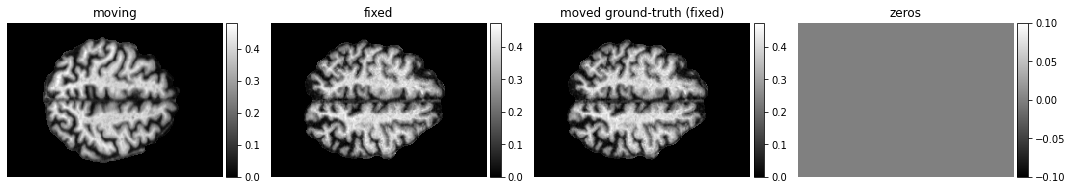

In [6]:
images = [img[0, :,50, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [7]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
  
vol_shape = x_train[0].shape
print(f'vol_shape = {vol_shape}')
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

def sum_of_squares_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
losses = [sum_of_squares_loss, vxm.losses.Grad('l2').loss]
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
lambda_param = 0.05
loss_weights = [1, lambda_param]

vol_shape = (160, 192, 224)


In [8]:
vxm_model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)

In [9]:
nb_epochs = 20
steps_per_epoch = (N * (N-1))//batch_size
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=1);

Epoch 1/20
564/564 [==============================] - 1595s 3s/step - loss: 53591.6289 - vxm_dense_transformer_loss: 53591.6250 - vxm_dense_flow_loss: 0.0643
Epoch 2/20
564/564 [==============================] - 1540s 3s/step - loss: 27272.0508 - vxm_dense_transformer_loss: 27272.0449 - vxm_dense_flow_loss: 0.1123
Epoch 3/20
564/564 [==============================] - 1553s 3s/step - loss: 23018.5703 - vxm_dense_transformer_loss: 23018.5625 - vxm_dense_flow_loss: 0.1255
Epoch 4/20
564/564 [==============================] - 1544s 3s/step - loss: 20791.5684 - vxm_dense_transformer_loss: 20791.5625 - vxm_dense_flow_loss: 0.1379
Epoch 5/20
564/564 [==============================] - 1545s 3s/step - loss: 19264.1543 - vxm_dense_transformer_loss: 19264.1445 - vxm_dense_flow_loss: 0.1480
Epoch 6/20
564/564 [==============================] - 1551s 3s/step - loss: 18115.7207 - vxm_dense_transformer_loss: 18115.7109 - vxm_dense_flow_loss: 0.1571
Epoch 7/20
564/564 [==============================] 

In [10]:
vxm_model.save_weights('vxm_ssd.h5')